In [1]:
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
import aplpy
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
import warnings
warnings.simplefilter('ignore')

In [2]:
import fil_finder
from fil_finder import FilFinder2D, Filament2D
from astropy.io import fits
import tqdm
import copy
import random
from matplotlib.colors import rgb2hex
import pandas as pd

In [3]:
import math
from scipy.stats import moment
import spectral_cube
from spectral_cube.spectral_cube import SpectralCube
import cv2
import skimage
#from PIL import Image
from scipy.ndimage import gaussian_filter
from glob import glob
import os

In [4]:
# fits_list = glob(os.path.join("/home/filament/Desktop/integ_fits_20220609_2/*.fits"))
fits_list = glob(os.path.join("/home/filament/Desktop/fil_result/integ_fits/region1/region1_V1_p120_m45.fits"))
# fits_list = glob(os.path.join("/home/filament/Documents/region1_hdr/V1*.fits"))

In [5]:
fits_list

['/home/filament/Desktop/fil_result/integ_fits/region1/region1_V1_p120_m45.fits']

In [6]:
integ_hdu_list = [fits.open(_)[0] for _ in fits_list]
w_list = [WCS(integ_hdu_list[i]) for i in range(len(fits_list))]

In [12]:
# fits_name = [_.split("/")[5] for _ in fits_list]
fits_name = [_.split("/")[7] for _ in fits_list]

In [13]:
fits_name

['region1_V1_p120_m45.fits']

In [14]:
# region_name = fits_name[0].split("_")[0]
region_name = fits_name[0].split("_")[0]

In [15]:
region_name

'region1'

In [16]:
data0 = np.zeros_like(integ_hdu_list[0].data)

In [17]:
fil_list = [FilFinder2D(integ_hdu_list[i], beamwidth=0.2706* u.deg) for i in range(len(fits_list))]

In [18]:
fil_list

In [19]:
[fil_list[i].preprocess_image(flatten_percent=95) for i in range(len(fits_list))]

[None]

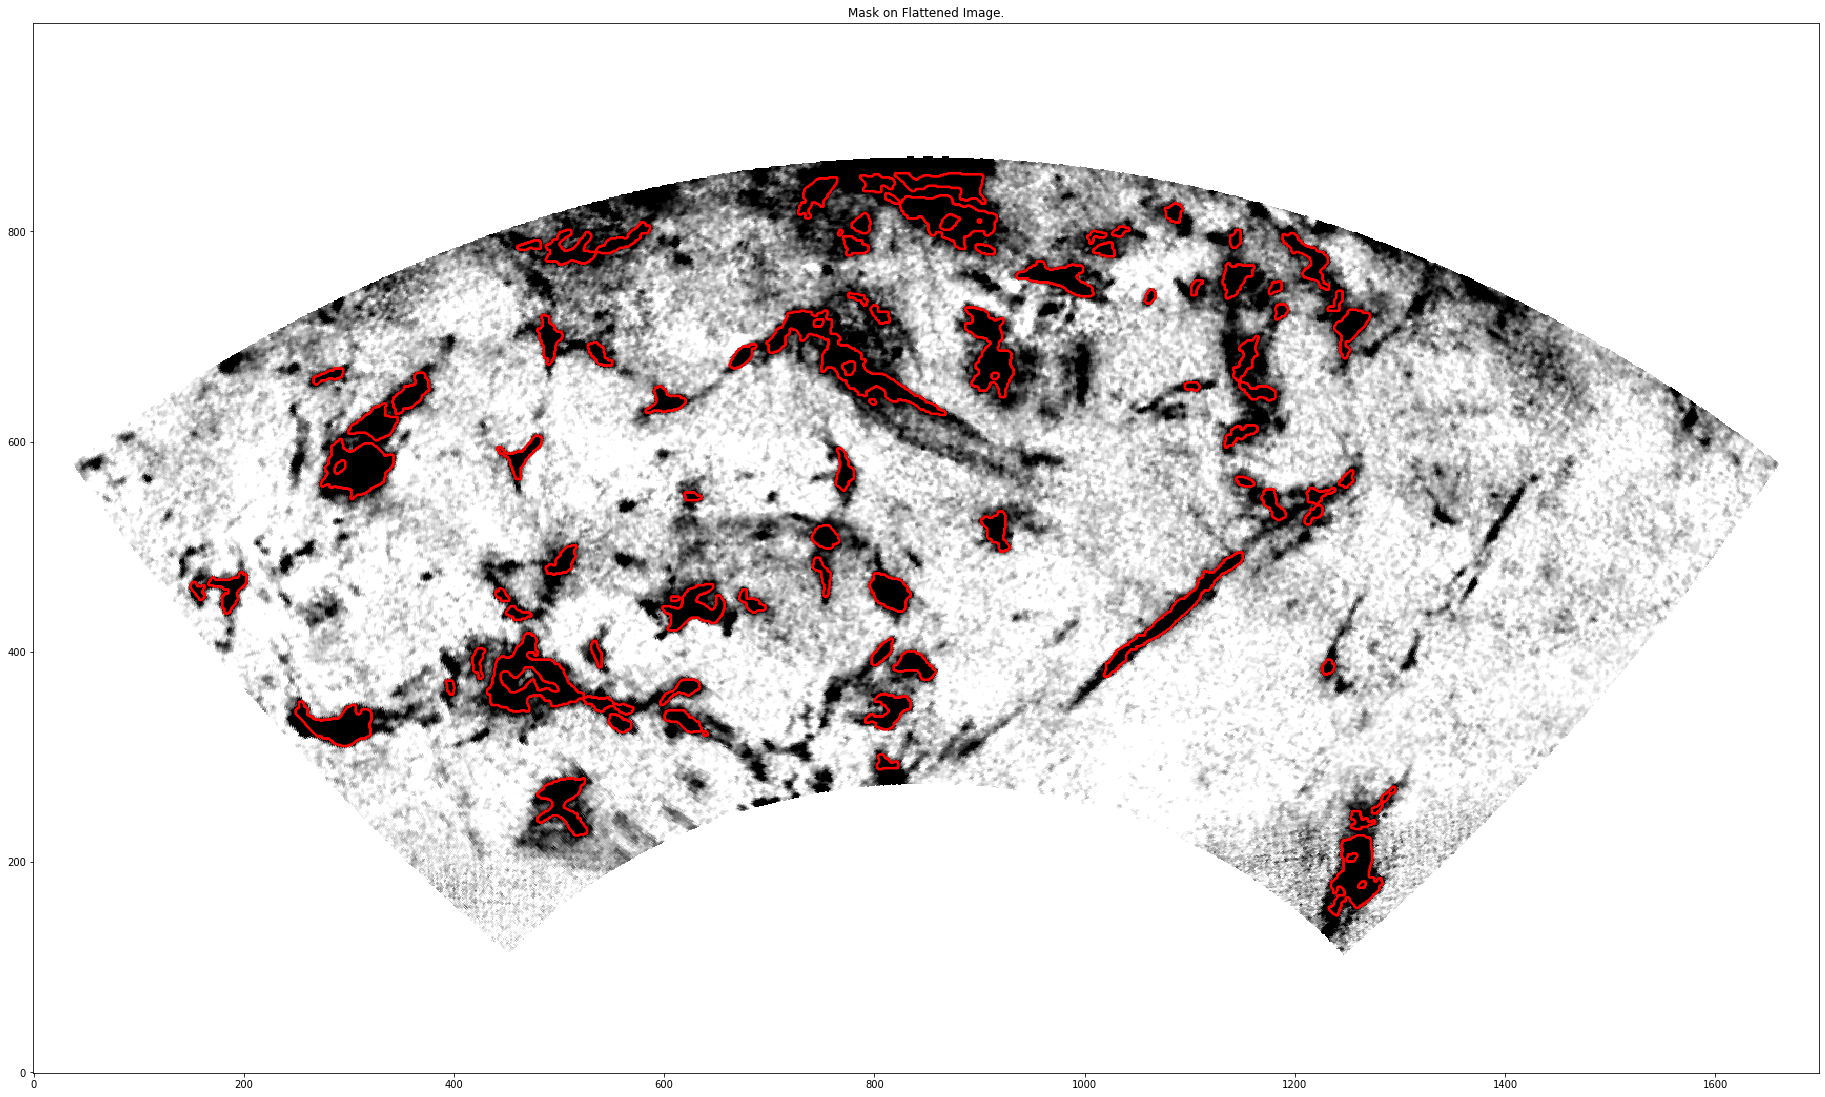

<Figure size 432x288 with 0 Axes>

In [20]:
for i in range(len(fits_list)):
    fig = plt.figure(figsize=(32, 32))
    #fil.create_mask(verbose=True)#,border_masking=False)
    fil_list[i].create_mask(verbose=True, adapt_thresh=5*u.pix, smooth_size=3*u.pix, size_thresh=100*u.pix*u.pix, glob_thresh=3)#, border_masking=False)
    plt.clf()

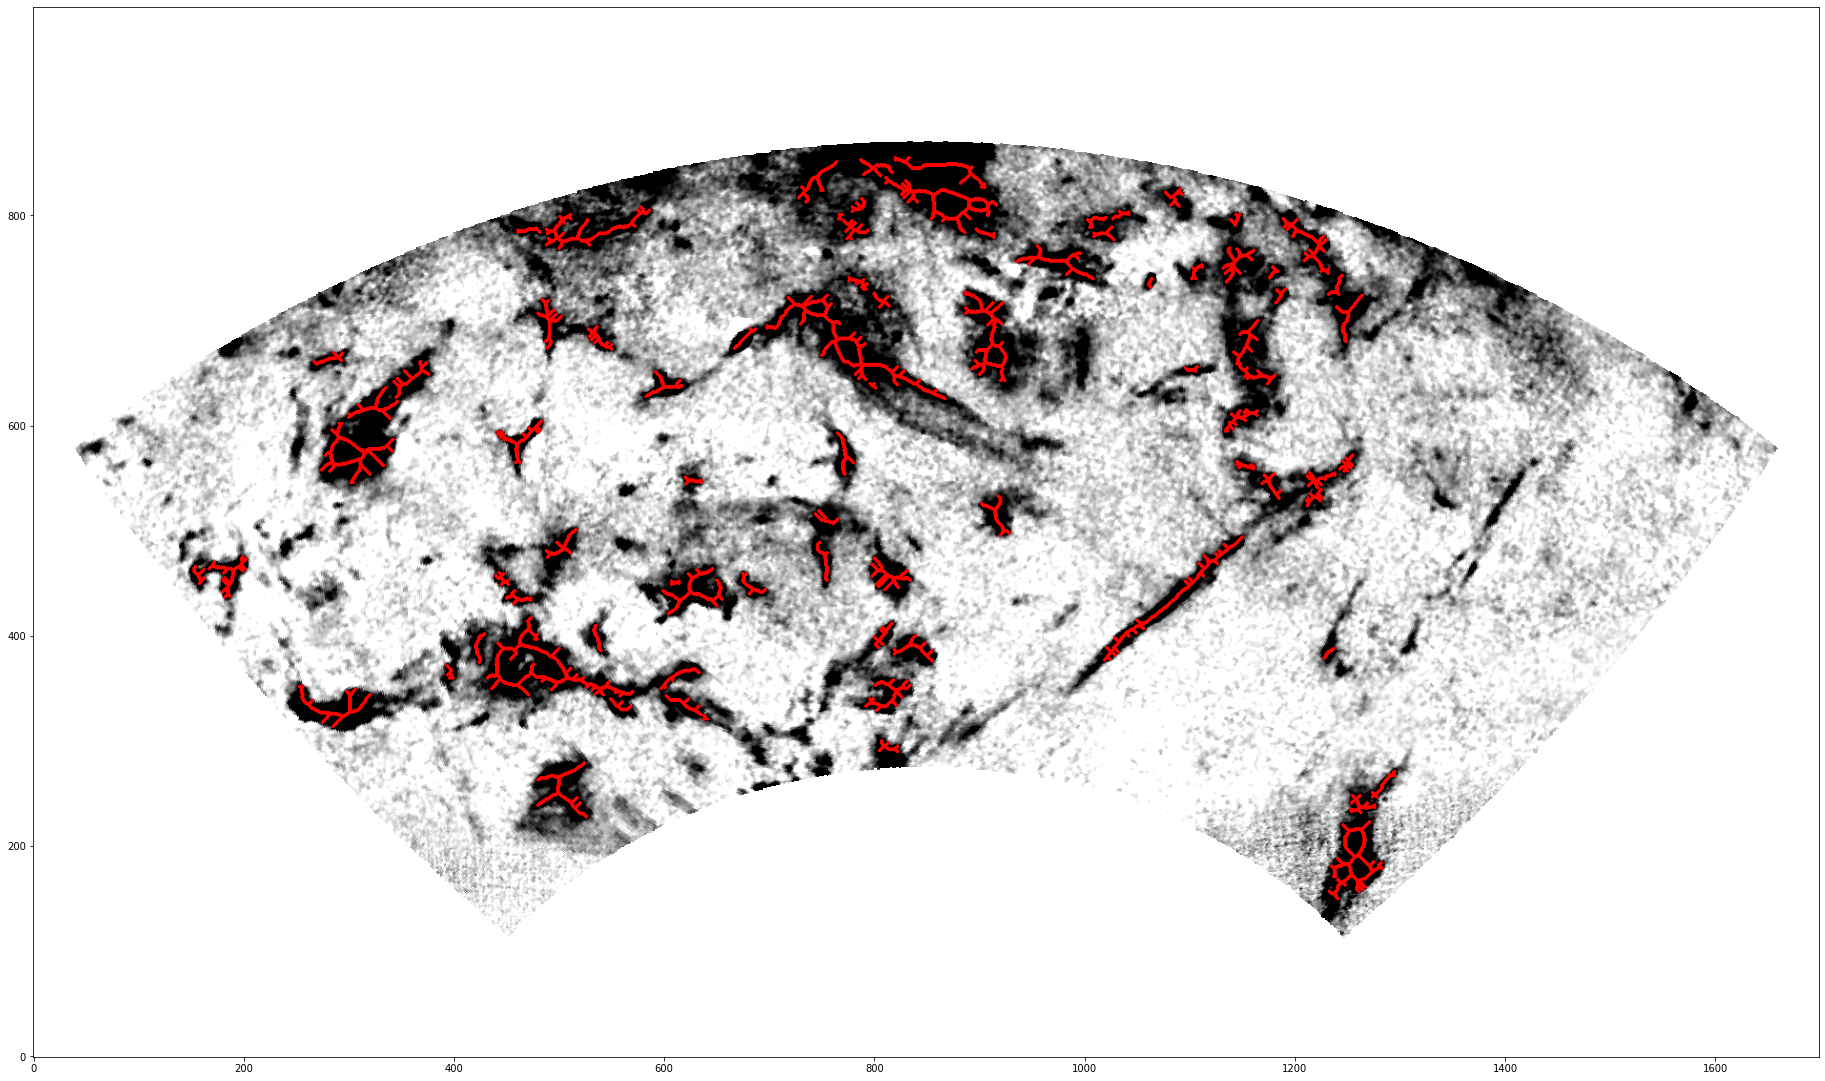

<Figure size 432x288 with 0 Axes>

In [21]:
for i in range(len(fits_list)):
    fig = plt.figure(figsize=(32, 32))
    fil_list[i].medskel(verbose=True)
    fil_skeleton= fil_list[i].skeleton
    fil_skeleton = fil_skeleton.astype("int")
    plt.clf()

In [22]:
for i in tqdm.tqdm(range(len(fil_list))):
    fil_list[i].analyze_skeletons(nbeam_lengths=3, branch_nbeam_lengths=3, branch_thresh=10*u.pix, skel_thresh=10*u.pix, prune_criteria='all')

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.09s/it]


100%|███████████████████████████████████████████| 76/76 [00:01<00:00, 47.57it/s]


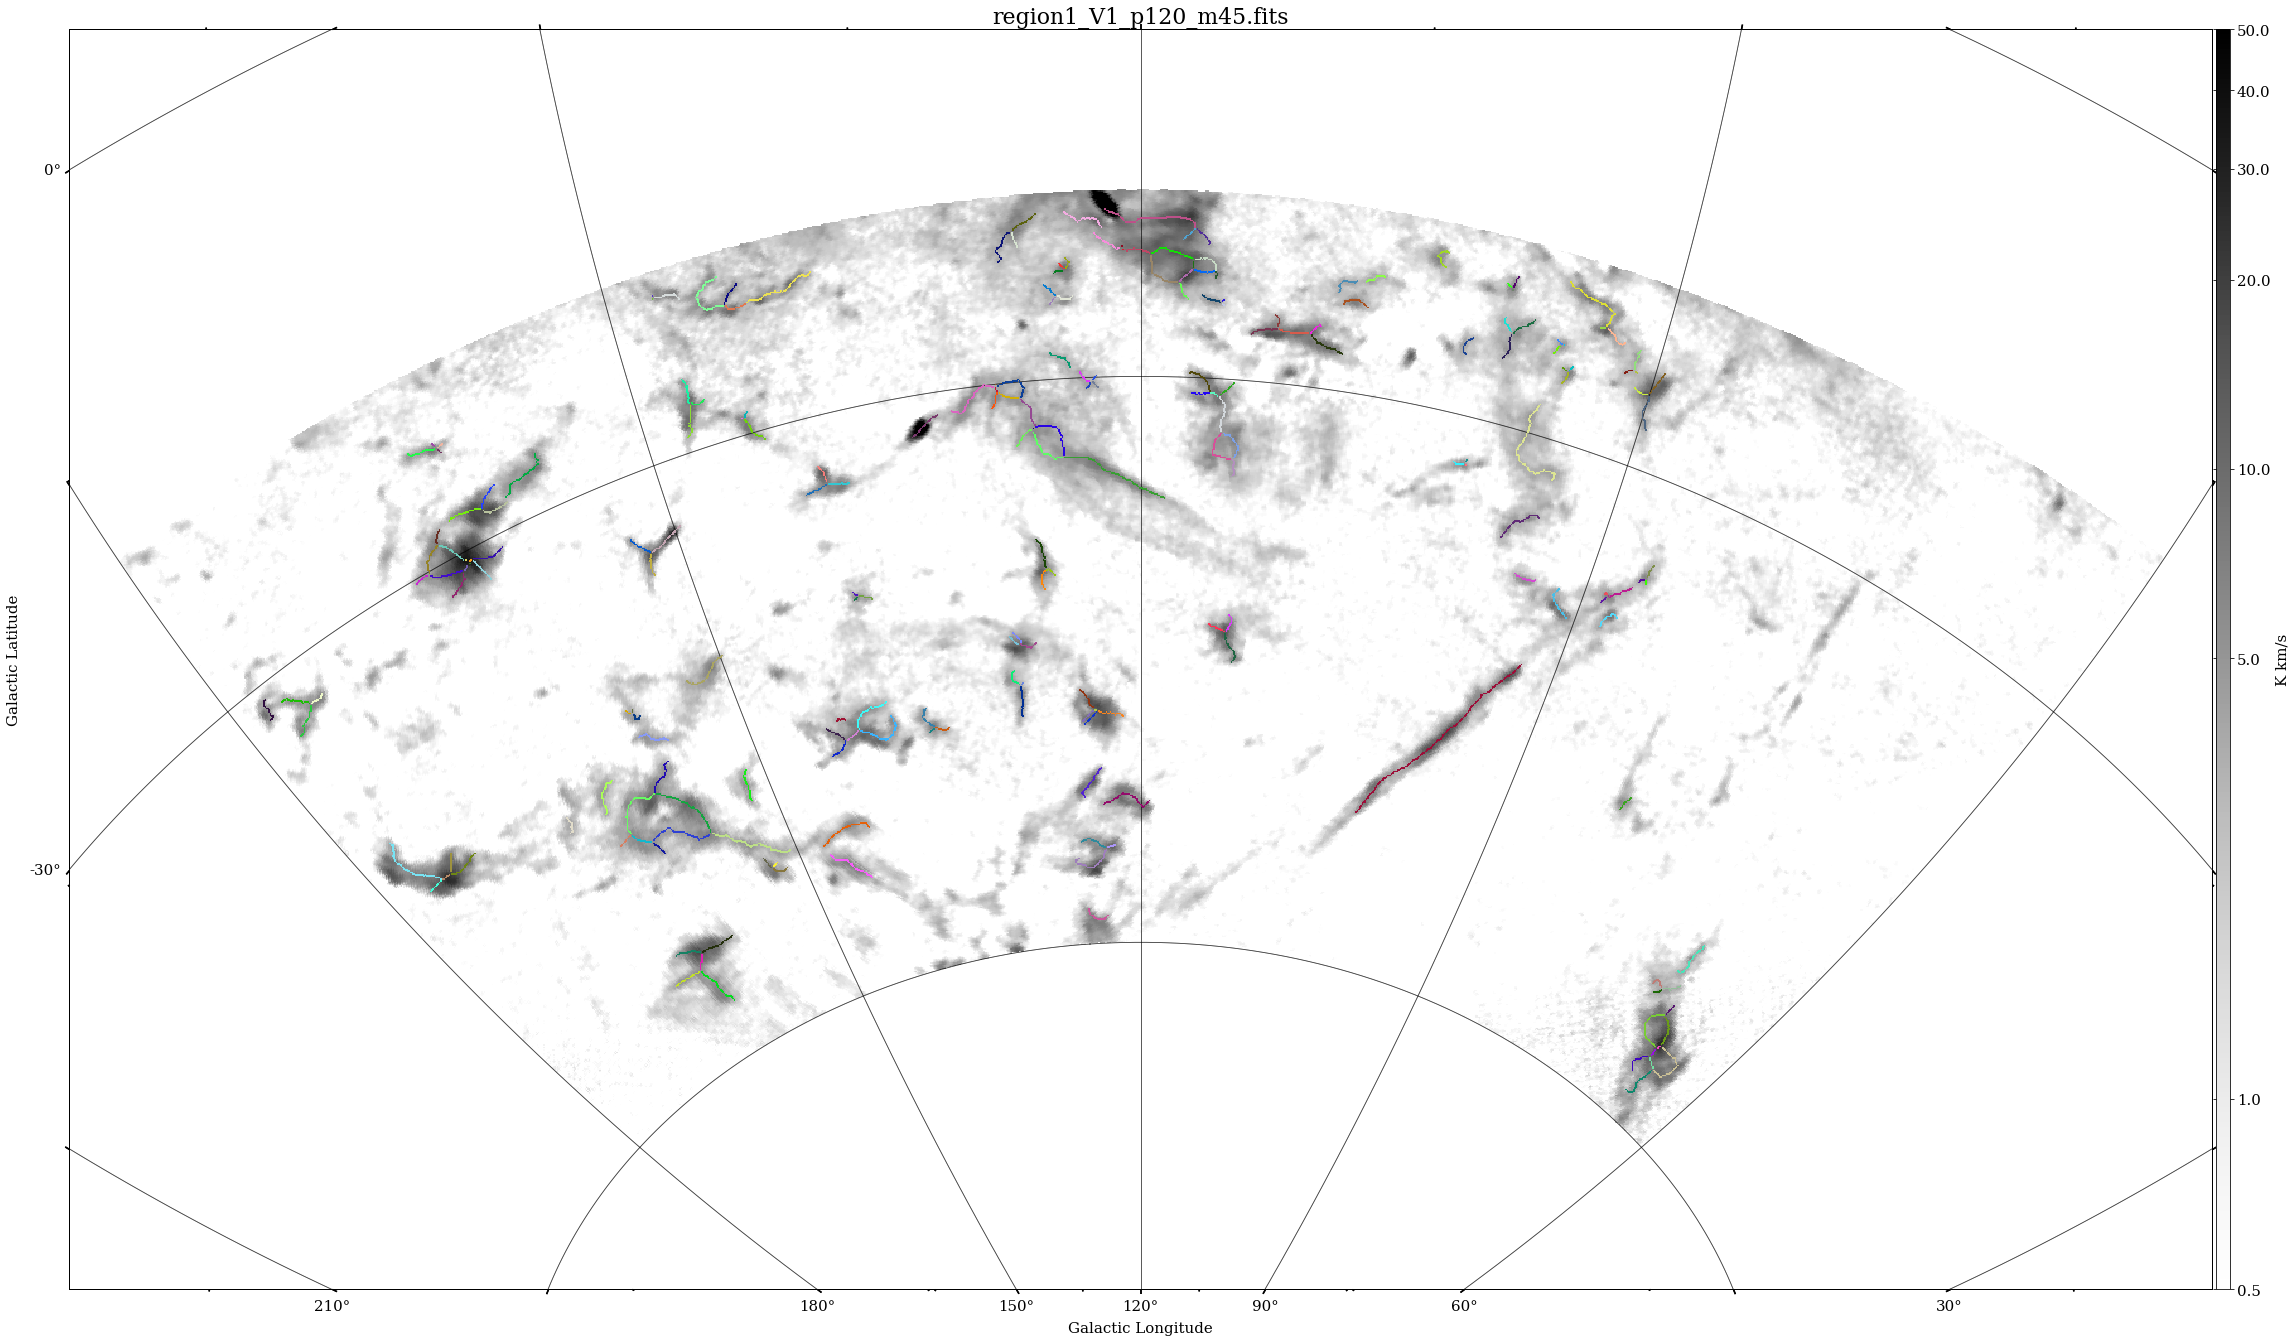

In [23]:
for k in range(len(fil_list)):
    fig = plt.figure(figsize=(32, 32))
    f = aplpy.FITSFigure(integ_hdu_list[k], slices=[0], figure=fig)
    f.show_colorscale(vmin = 0.5, vmax = 50, stretch="log", cmap="Greys")
    f.add_colorbar()
    f.colorbar.show()
    f.colorbar.set_width(0.2)
    f.colorbar.set_ticks([0.5, 1, 5, 10, 20, 30, 40, 50])
    f.colorbar.set_font(size=15, family='serif')
    f.colorbar.set_axis_label_text("K km/s")
    f.colorbar.set_axis_label_font(size=15, family='serif')

    cmap = plt.get_cmap("gist_rainbow")
    d = copy.deepcopy(data0)
    pos_x_wcs_list = []
    pos_y_wcs_list = []
    color_tempo_list = []
    w = w_list[k]
    for fil_tempo in tqdm.tqdm(fil_list[k].filaments):
        y_start, x_start = fil_tempo.pixel_extents[0][0], fil_tempo.pixel_extents[0][1]
#         print(y_start,"y_start", x_start,"x_start")
        #y_size, x_size = fil_tempo.skeleton().shape
        fil_tempo.rht_branch_analysis()
        ori_branches_tempo = np.rad2deg(fil_tempo.orientation_branches.value)
#         print("ori_branches_tempo",ori_branches_tempo)
        for i in range(len(fil_tempo.branch_pts())):
            pixels_tempo = fil_tempo.branch_properties["pixels"][i]
            y_pix_all = pixels_tempo[:,0]
            x_pix_all = pixels_tempo[:,1]
#             print(pixels_tempo,"pixels_tempo")
#             print(y_pix_all,"y_pix_all")
#             print(x_pix_all,"x_pix_all")
            pos_x_tempo = int(np.nanmax(x_pix_all)/2-np.nanmin(x_pix_all)/2)+np.nanmin(x_pix_all)+x_start
            pos_y_tempo = int(np.nanmax(y_pix_all)/2-np.nanmin(y_pix_all)/2)+np.nanmin(y_pix_all)+y_start
            ori_branch_tempo = ori_branches_tempo[i]
            pos_x_wcs_tempo, pos_y_wcs_tempo = w.wcs_pix2world(pos_x_tempo, pos_y_tempo, 0)
            pos_x_wcs_array, pos_y_wcs_array = w.wcs_pix2world(x_pix_all+x_start, y_pix_all+y_start, 0)
            color_tempo_list += ["#%06x" % random.randint(0, 0xFFFFFF)]*len(pos_x_wcs_array)
            pos_x_wcs_list += list(pos_x_wcs_array)
            pos_y_wcs_list += list(pos_y_wcs_array)
    f.show_markers(pos_x_wcs_list, pos_y_wcs_list, marker="s", s=3, facecolor=color_tempo_list, edgecolor="none", zorder=11)

    f.ticks.set_length(5, minor_factor=0.5)  # points
    f.ticks.set_color('k')
    f.ticks.set_linewidth(1.5)  # points
    f.ticks.set_minor_frequency(2)
    # f.tick_labels.set_xformat('dd.d')
    # f.tick_labels.set_yformat('dd.d')
    f.tick_labels.set_font(size=15, family='serif')
    f.axis_labels.set_font(size=15, family='serif')

    f.add_grid()
    f.grid.set_color("k")
    f.grid.set_xspacing(30)
    f.grid.set_xspacing(30)
    
    f.set_title(fits_name[k], family="serif", size=22)

    plt.tight_layout()
    fig.patch.set_facecolor('w')
#     f.save("./fil_random_%s.pdf"%fits_name[k], dpi=200)
#     f.save("./fil_random_%s.png"%fits_name[k], dpi=200)
    f.save("/home/filament/Documents/region1_hdr/fil_random_%s.png"%(fits_name[k]), dpi=200)
    f.save("/home/filament/Documents/region1_hdr/fil_random_%s.pdf"%(fits_name[k]), dpi=200)
    plt.show()

In [24]:
lean_map_ls = []

for i in range(len(integ_hdu_list)):
    lean_map = np.zeros_like(integ_hdu_list[i].data)
    w = WCS(integ_hdu_list[i])
    x_ch_array = np.arange(integ_hdu_list[i].data.shape[1])
    y_ch_array = np.arange(integ_hdu_list[i].data.shape[0])
    X, Y = np.meshgrid(x_ch_array, y_ch_array)
    pos_wcs = w.wcs_pix2world(X, Y, 0)
    pos_pix_p = w.wcs_world2pix(pos_wcs[0], pos_wcs[1]+0.00001, 0)
    pos_pix_m = w.wcs_world2pix(pos_wcs[0], pos_wcs[1]-0.00001, 0)
    ratio_map = -(pos_pix_p[0] - pos_pix_m[0])/(pos_pix_p[1] - pos_pix_m[1])
    lean_map = np.rad2deg(np.arctan(ratio_map))
    lean_map_ls.append(lean_map)


In [25]:
for i in range(len(integ_hdu_list)):
    print(integ_hdu_list[i].data.shape,lean_map_ls[i].shape)
    

(999, 1699) (999, 1699)


In [26]:
# plt.plot(fil_list[0].filaments[0].skeleton())

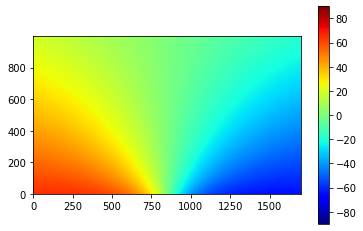

In [29]:
plt.imshow(lean_map, origin="lower", cmap="jet", vmin=-90, vmax=90)
plt.colorbar()

In [30]:
ori_dict = {}
glon_dict = {}
glat_dict = {}
for k, v_range in enumerate(fits_name):
    ori_list = []
    glon_list = []
    glat_list = []
    w = WCS(integ_hdu_list[k])
    for fil_tempo in tqdm.tqdm(fil_list[k].filaments):
        y_start, x_start = fil_tempo.pixel_extents[0][0], fil_tempo.pixel_extents[0][1]
        #y_size, x_size = fil_tempo.skeleton().shape
        fil_tempo.rht_branch_analysis()
        ori_branches_tempo = np.rad2deg(fil_tempo.orientation_branches.value)
        for i in range(len(fil_tempo.branch_pts())):
            pixels_tempo = fil_tempo.branch_properties["pixels"][i]
            y_pix_all = pixels_tempo[:,0]
            x_pix_all = pixels_tempo[:,1]
            pos_x_tempo = int(np.nanmax(x_pix_all)/2-np.nanmin(x_pix_all)/2)+np.nanmin(x_pix_all)+x_start
            pos_y_tempo = int(np.nanmax(y_pix_all)/2-np.nanmin(y_pix_all)/2)+np.nanmin(y_pix_all)+y_start
            _ = w.wcs_pix2world(pos_x_tempo, pos_y_tempo, 0)
            glon_list.append(_[0])
            glat_list.append(_[1])
            ori_list.append(ori_branches_tempo[i] - lean_map_ls[k][pos_y_tempo, pos_x_tempo])
    ori_array = np.array(ori_list)
    glon_array = np.array(glon_list)
    glat_array = np.array(glat_list)
    glon_array = np.where(glon_array>180, glon_array-360, glon_array)
    glon_array = np.where(glon_array<-180, glon_array+360, glon_array)
    ori_array = np.where(ori_array>90, ori_array-180, ori_array)
    ori_array = np.where(ori_array<-90, ori_array+180, ori_array)
    ori_dict[v_range] = ori_array
    glon_dict[v_range] = glon_array
    glat_dict[v_range] = glat_array

100%|███████████████████████████████████████████| 76/76 [00:01<00:00, 46.16it/s]


In [32]:
for i in range(len(fil_list)):
    fil_list[i].find_widths()

In [33]:
integ_hdu_list[0].data.shape[0]*integ_hdu_list[0].data.shape[1]

1697301

In [34]:
fil_list

In [35]:
total_intensity_list = []

for i in range(len(fil_list)):
    HI_tot_int = 0
    for j in range(len(integ_hdu_list[i].data)):
        HI_tot_int += np.nansum(integ_hdu_list[i].data[j])
    total_intensity_list.append(HI_tot_int)
        

In [36]:
total_intensity_list

[778058.5657723618]

In [37]:
fil_total_intensity_arr = [[i.total_intensity().value for i in fil_list[j].filaments] for j in range(len(fil_list))]

In [38]:
fil_total_intensity_list = [np.nansum(fil_total_intensity_arr[i]) for i in range(len(fil_total_intensity_arr))]

In [39]:
fil_total_intensity_list

[252938.3492920641]

In [40]:
ratio_list = [(fil_total_intensity_list[i] / total_intensity_list[i])*100 for i in range(len(fil_total_intensity_list))]

In [41]:
ratio_list

[32.508908765881614]

In [42]:
import pickle
with open("ori_dict.pkl", "wb") as f:
    pickle.dump(ori_dict, f)
with open("glon_dict.pkl", "wb") as f:
    pickle.dump(glon_dict, f)
with open("glat_dict.pkl", "wb") as f:
    pickle.dump(glat_dict, f)

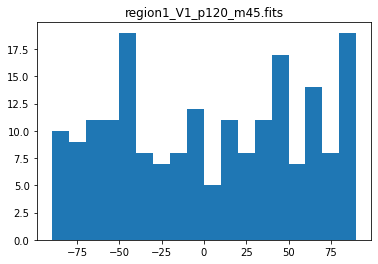

In [43]:
for k in range(len(fits_list)):
    plt.hist(ori_dict[fits_name[k]], bins=np.linspace(-90, 90, num=19))
    plt.title(fits_name[k])
#     plt.savefig("/home/filament/Desktop/fil_result/center_move/%s/PA_%s.png"%(region_name,fits_name[k]), dpi=200)
    plt.savefig("/home/filament/Desktop/fil_result/center_move/region1/PA_%s.png"%(fits_name[k]), dpi=200)
    plt.show()
    plt.show()

In [44]:
region_name

'region1'

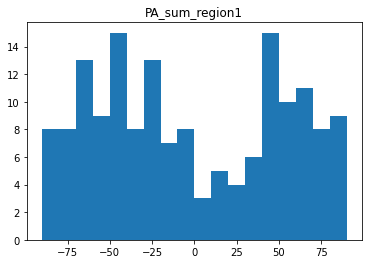

In [44]:
sum_ori = []

for i in range(len(fits_name)):
    sum_ori.extend(ori_dict[fits_name[i]])
    
plt.hist(sum_ori, bins = np.linspace(-90,90, num = 19))
plt.title("PA_sum_region1")
plt.savefig("/home/filament/Desktop/fil_result/center_move/region1/PA_sum_region1.png", dpi=200)
plt.show()

In [91]:
print(len(sum_ori))
len(ori_dict[fits_name[0]])+len(ori_dict[fits_name[1]])+len(ori_dict[fits_name[2]])+len(ori_dict[fits_name[3]])

180


180

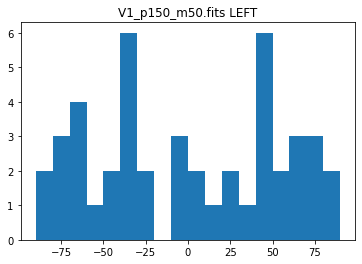

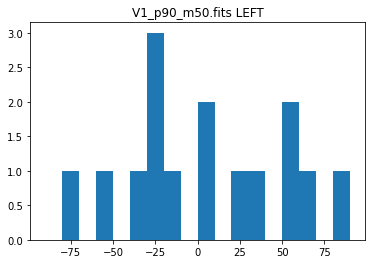

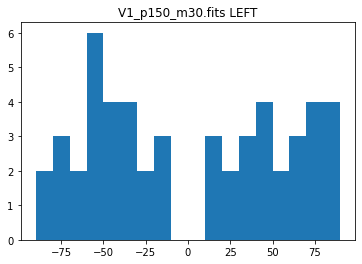

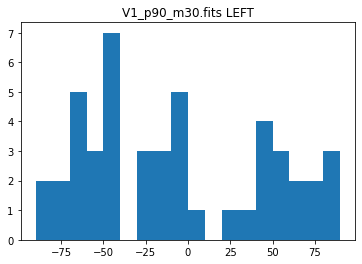

In [93]:
for k in range(len(fits_list)):
    plt.hist(ori_dict[fits_name[k]][glon_dict[fits_name[k]]>60], bins=np.linspace(-90, 90, num=19))
    plt.title(fits_name[k]+" LEFT")
    plt.show()

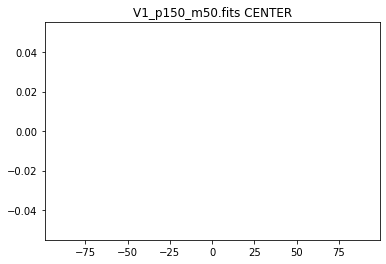

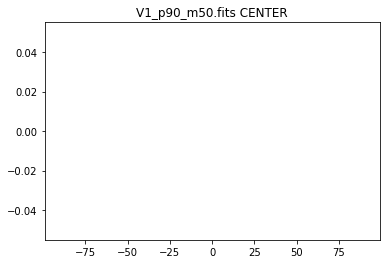

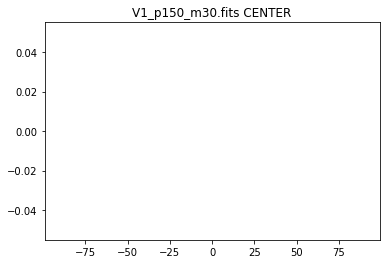

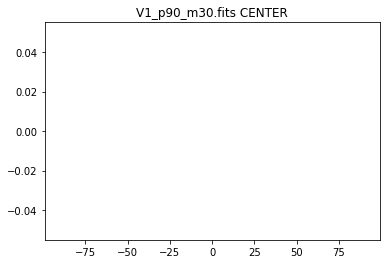

In [94]:
for k in range(len(fits_list)):
    plt.hist(ori_dict[fits_name[k]][(glon_dict[fits_name[k]]<=60) & (glon_dict[fits_name[k]]>=-60)], bins=np.linspace(-90, 90, num=19))
    plt.title(fits_name[k]+" CENTER")
    plt.show()

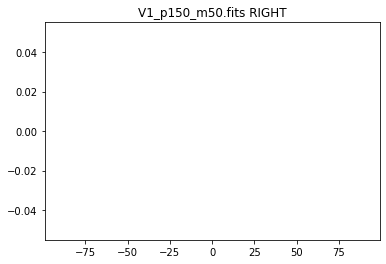

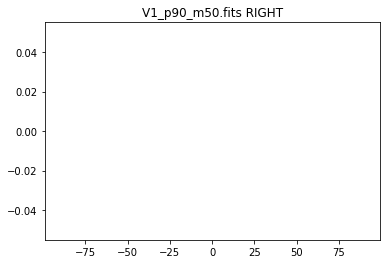

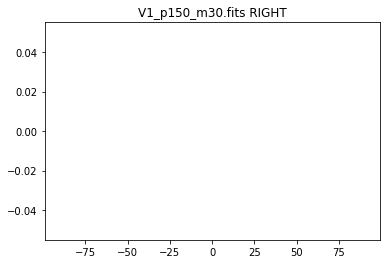

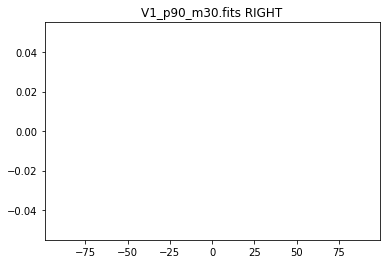

In [95]:
for k in range(len(fits_list)):
    plt.hist(ori_dict[fits_name[k]][glon_dict[fits_name[k]]<=-60], bins=np.linspace(-90, 90, num=19))
    plt.title(fits_name[k]+" RIGHT")
    plt.show()